## PreProcess Images and feed into CNN

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# Install package to handle .tiff data
!pip install pyrsgis

In [3]:
# Clone my git repo for preprocessing the images

!git clone https://github.com/maxjonasbehrens/master_thesis_code
#%cd /content/master_thesis_code
#!git pull

Cloning into 'master_thesis_code'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 290 (delta 149), reused 191 (delta 84), pack-reused 0
Receiving objects: 100% (290/290), 763.12 KiB | 14.96 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [0]:
# Load Python script for preprocessing
%load /content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py

In [3]:
# Load necessary packages
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import scipy.io
import sklearn.model_selection

Warning! matplotlib_scalebar library not found.


In [0]:
# Import own module to preprocess images
import imp
sat_images = imp.new_module('sat_images')
exec(open("/content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py").read(), sat_images.__dict__)

## Test for one image

In [0]:
# Download test image from drive
img_path = "/gdrive/My Drive/nuts_geotiff/BE34_2013.tif"

ds1, img = pyrsgis.raster.read(img_path)

In [25]:
# Print its shape
print("Image shape: ",img.shape)

Image shape:  (3, 1299, 1482)


In [0]:
# Resize original image to compatible size
img = np.swapaxes(img,0,-1)
orig_resized = resize(img, (1024,1024))

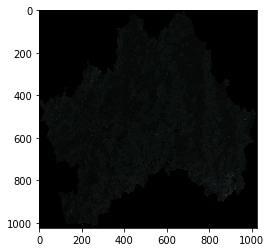

In [27]:
# Show the original image
plt.imshow(orig_resized, interpolation='nearest')
plt.show()

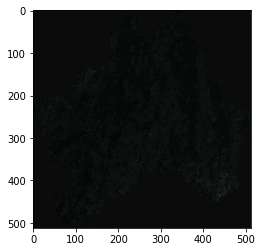

In [28]:
# Test replacing nan values with mean or samples from normal distribution

mu, sigma = np.nanmean(img), np.nanstd(img)
processed_img = img
#processed_img = resize(processed_img, (512,512))
n_nan = len(processed_img[np.isnan(processed_img)])
processed_img[np.isnan(processed_img)] = mu#np.random.normal(mu,sigma,n_nan)
processed_img = resize(processed_img, (512,512))
plt.imshow(processed_img, interpolation='nearest')
plt.show()

# Create input data

In [9]:
# Load Data Frame of NUTS regions and corresponding gdp values
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
y_dat.head()

,nuts2,year,nuts_value,code,country,country_value,mean_value,diff_value
0,BE10,2008,61100.0,BE,Belgium,33100.0,31881.818182,28000.0
1,BE21,2008,39200.0,BE,Belgium,33100.0,31881.818182,6100.0
2,BE22,2008,27500.0,BE,Belgium,33100.0,31881.818182,-5600.0
3,BE23,2008,29400.0,BE,Belgium,33100.0,31881.818182,-3700.0
4,BE24,2008,34500.0,BE,Belgium,33100.0,31881.818182,1400.0


In [0]:
# Benchmark for diff-value (other benchmark are in other script)
mae_diff = np.mean(abs(y_dat['diff_value']-y_dat['diff_value'].mean()))
print(mae_diff)

5478.004371660496


In [0]:
# List of all files in directory of images
mypath = "/gdrive/My Drive/nuts_night/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [10]:
# PreProcess images with certain resolution
res = 512
x,y,label = sat_images.create_data(onlyfiles,mypath,y_dat,prediction='nuts_value',replace_nan='mean',resolution=res,night=False)

Image processed:  0  of  1253
Image processed:  10  of  1253
Image processed:  20  of  1253
Image processed:  30  of  1253
Image processed:  40  of  1253
Image processed:  50  of  1253
Image processed:  60  of  1253
Image processed:  70  of  1253
Image processed:  80  of  1253
Image processed:  90  of  1253
Image processed:  100  of  1253
Image processed:  110  of  1253
Image processed:  120  of  1253
Image processed:  130  of  1253
Image processed:  140  of  1253
Image processed:  150  of  1253
Image processed:  160  of  1253
Image processed:  170  of  1253
Image processed:  180  of  1253
Image processed:  190  of  1253
Image processed:  200  of  1253
Image processed:  210  of  1253
Image processed:  220  of  1253
Image processed:  230  of  1253
Image processed:  240  of  1253
Image processed:  250  of  1253
Image processed:  260  of  1253
Image processed:  270  of  1253
Image processed:  280  of  1253
Image processed:  290  of  1253
Image processed:  300  of  1253
Image processed:  3

### Save NIGHT images

In [0]:
# Save ndarray to reproduce in drive for NIGHT images
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_night_normal_512.mat", mdict={'x': x}, oned_as='row')

### Save DAY images

In [0]:
# Save ndarray to reproduce in drive for DAY images
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_day_mean_512_1.mat", mdict={'x': x[:600]}, oned_as='row')
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_day_mean_512_2.mat", mdict={'x': x[600:]}, oned_as='row')

In [0]:
# Load input from scratch

# For DAY images
#x = np.vstack((scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_mean_512_1.mat")['x'],scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_mean_512_2.mat")['x']))

# For NIGHT images
x = scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_night_mean_512.mat")['x']

y, label = sat_images.create_y_label(onlyfiles,mypath,y_dat,prediction='nuts_value')

In [47]:
# Print shape of images
print('Shape of x: ',len(x))
print('Shape of y: ',len(y))
print('Shape of labels: ', len(label))

Shape of x:  692
Shape of y:  692
Shape of labels:  692


In [48]:
# Convert grayscale 1-channel to 3-channel (only for transfer learning)
x = np.stack((x,)*3, axis=-1)
print(x.shape)

(692, 512, 512, 3)


# Create Train and Test Sets

In [49]:
# Create list of unique regions
regions = []
for i in range(len(label)):
  regions.append(label[i].rsplit('_',1)[0])

regions = np.unique(regions)
print(len(regions))

117


In [50]:
# Split regions into train and test set
msk_test = np.random.rand(len(regions)) < 0.2

train_split = regions[~msk_test]
test_split = regions[msk_test]

msk_val = np.random.rand(len(train_split)) < 0.25

val_split = train_split[msk_val]
train_split = train_split[~msk_val]
print(len(train_split))
print(len(val_split))
print(len(test_split))

62
25
30


In [51]:
# Split whole data set into test and train based on split regions
import math
label_train = []
label_val = []
label_test = []
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

# Split into train and test based on previous region split
for i in range(len(label)):
  if label[i].rsplit('_',1)[0] in train_split:
    if math.isnan(y[i]):
      pass
    else:
      label_train.append(label[i])
      x_train.append(x[i])
      y_train.append(int(y[i]))
  elif label[i].rsplit('_',1)[0] in val_split:
    if math.isnan(y[i]):
      pass
    else:
      label_val.append(label[i])
      x_val.append(x[i])
      y_val.append(int(y[i]))
  else:
    if math.isnan(y[i]):
      pass
    else:
      label_test.append(label[i])
      x_test.append(x[i])
      y_test.append(int(y[i]))

# Transform into numpy array
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)  
y_val = np.array(y_val)

# Print Shape
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)

(364, 512, 512, 3)
(178, 512, 512, 3)
(178,)
(150, 512, 512, 3)


In [0]:
# Only execute when using night images, since they are 1d
x_train = np.array([x_train])
x_train = np.moveaxis(x_train,0,-1)
print(x_train.shape)
x_val = np.array([x_val])
x_val = np.moveaxis(x_val,0,-1)
print(x_val.shape)
x_test = np.array([x_test])
x_test = np.moveaxis(x_test,0,-1)
print(x_test.shape)

(410, 128, 128, 3, 1)
(162, 128, 128, 3, 1)
(120, 128, 128, 3, 1)


In [52]:
# Normalise the data
x_train = (x_train/np.max(x_train))
x_test = (x_test/np.max(x_test))
x_val = (x_val/np.max(x_val))
print(np.max(x_train))

1.0


# Start CNN Training

In [0]:
# Fully connected model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

In [0]:
# Deep Model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=(512,512,1), activation='relu'))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(512, activation='relu',activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1,activation='relu'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
# Shallow Model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(16, 3, padding='same', input_shape=(512,512,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='normal', activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, kernel_initializer='normal',activation='relu'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Transfer Learning
base_model = tf.keras.applications.VGG16(input_shape=(512,512,3),include_top=False)
x=base_model.output
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dropout(0.5)(x) #Dropout
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
x=tf.keras.layers.Dropout(0.5)(x) #Dropout
preds=tf.keras.layers.Dense(units=1, activation = 'relu')(x)
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

In [0]:
for layer in model.layers[:15]:
  layer.trainable = False

In [0]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optim, metrics=['mse','mae'], )

In [0]:
# Data Augmentation
training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                                          rotation_range = 40)
validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
# Data Preparation
batch_size = 5

# Define the data flow
training_generator = training_data_generator.flow(x_train,y_train,batch_size=batch_size)
validation_generator = validation_data_generator.flow(x_val, y_val,batch_size=batch_size)
test_generator = test_data_generator.flow(x_test,y_test,batch_size=1,shuffle=False)

In [78]:
# Calculate the number of steps
training_steps = training_generator.n/batch_size
validation_steps = validation_generator.n/batch_size

# Run the model
model.fit_generator(training_generator,
                    steps_per_epoch=training_steps,
                    epochs = 50,
                    validation_data = validation_generator,
                    validation_steps = validation_steps,
                    verbose = 1
                   )

Epoch 1/50
73/72 [==============================] - 28s 379ms/step - loss: 207397075.7320 - mean_squared_error: 207829424.0000 - mean_absolute_error: 11275.3857 - val_loss: 176452087.0500 - val_mean_squared_error: 176452080.0000 - val_mean_absolute_error: 9257.7412
Epoch 2/50
73/72 [==============================] - 22s 296ms/step - loss: 173170291.8946 - mean_squared_error: 173315776.0000 - mean_absolute_error: 10185.1992 - val_loss: 178191588.0667 - val_mean_squared_error: 178191600.0000 - val_mean_absolute_error: 9142.6641
Epoch 3/50
73/72 [==============================] - 23s 309ms/step - loss: 168923035.2007 - mean_squared_error: 169337360.0000 - mean_absolute_error: 10095.2568 - val_loss: 190198766.4000 - val_mean_squared_error: 190198736.0000 - val_mean_absolute_error: 9710.7471
Epoch 4/50
73/72 [==============================] - 23s 309ms/step - loss: 108561891.2016 - mean_squared_error: 108749016.0000 - mean_absolute_error: 7893.7485 - val_loss: 161888816.8333 - val_mean_squa

In [0]:
model.save_weights('/gdrive/My Drive/ThesisData/CNN_weights/transfer_tuned_night_model.h5')

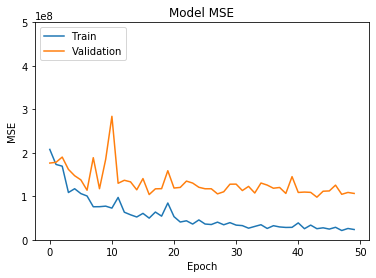

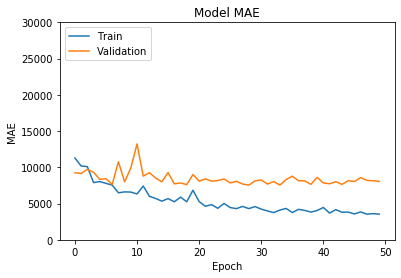

In [80]:
# Plot training & validation accuracy values
plt.plot(model.history.history['mean_squared_error'])
plt.plot(model.history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.ylim((0,500000000))
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['mean_absolute_error'])
plt.plot(model.history.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.ylim((0,30000))
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [81]:
# Calculate the test performance
test_score = model.evaluate_generator(test_generator)
print('Test loss: '+str(test_score[0]))
print('Test MSE: '+str(test_score[1]))
print('Test MAE: '+str(test_score[2]))

Test loss: 186808695.88163295
Test MSE: 186808670.0
Test MAE: 9065.637


# Better Fine-Tuning

In [69]:
model = tf.keras.applications.VGG16(input_shape=(512,512,3),include_top=False,weights='imagenet')
model.output_shape

(None, 16, 16, 512)

In [68]:
top_model = tf.keras.Sequential()
top_model.add(tf.keras.layers.Flatten(input_shape=(512,512,3)))
top_model.add(tf.keras.layers.Dense(256, activation='relu'))
top_model.add(tf.keras.layers.Dropout(0.5))
top_model.add(tf.keras.layers.Dense(1, activation='relu'))

top_model.load_weights('/gdrive/My Drive/ThesisData/CNN_weights/fc_night_model.h5')

model.add(top_model)

AttributeError: ignored